In [1]:
%%capture
! pip install lime
! pip install shap

# Load Dataset

In [2]:
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder
from lightgbm import LGBMClassifier
from sklearn.metrics.pairwise import cosine_similarity
from typing import List


In [10]:
data_path = './anime/'

# Read the dataset
animes = pd.read_csv(data_path+'anime.csv')
ratings = pd.read_csv(data_path+'rating.csv')


# Preprocessing & Feature Engineering

In [11]:
# 사용하는 피처만 남김
animes = animes[['anime_id', 'type', 'rating', 'members', 'name', 'genre']]
# 칼럼명 변경
animes.columns = ['anime_id', 'type', 'anime_total_rating', 'members', 'name', 'genre']
# 결측값이 포함된 애니는 drop
animes = animes.dropna()


# 평점 테이블도 동일하게 처리, 무효한 값은 제거 (rating이 -1인 값)
ratings = ratings[['user_id', 'anime_id', 'rating']]
ratings = ratings[ratings['rating'] != -1]

# 데이터 프레임 join
data = ratings.merge(animes, on='anime_id', how='inner')

# 유저 정보가 없으므로, 유저의 평점 패턴에서 유저 피처 추출 (평균 평점 및 평점을 내린 수)
user_avg_rating = data.groupby('user_id')['rating'].mean().rename('User-AvgRating')
user_num_ratings = data.groupby('user_id')['rating'].count().rename('User-NumRatings')

# 추출한 유저 피처 결합
user_features = pd.concat([user_avg_rating, user_num_ratings], axis=1)

# 애니 메타 데이터에서 아이템 관련 피처 수가 생성
item_num_ratings = data.groupby('anime_id')['rating'].count().rename('Item-NumRatings')

# 애니 이름 피처에서 TF-IDF 피처 생성, 총 10개의 이름 생성 (most frequent 10 words)
tfidf_vectorizer = TfidfVectorizer(max_features=10)
item_name_tfidf = tfidf_vectorizer.fit_transform(animes['name']).toarray()

tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()

# 'type' 칼럼을 원핫 인코딩
onehot_encoder = OneHotEncoder(sparse_output=False)
item_type_onehot = onehot_encoder.fit_transform(animes[['type']])

# TF-IDF 피처와 type 원핫 피처를 결합
tf_idf_df = pd.DataFrame(item_name_tfidf, columns=tfidf_feature_names, index=animes.anime_id)
type_df = pd.DataFrame(item_type_onehot, columns=[f'Type-{cat}' for cat in onehot_encoder.categories_[0]], index=animes.anime_id)

animes_features = animes[['anime_id', 'members', 'anime_total_rating']]


item_features = pd.DataFrame(item_num_ratings)\
            .merge(tf_idf_df, on="anime_id")\
            .merge(type_df, on="anime_id")\
            .merge(animes_features.set_index('anime_id'), on="anime_id")


# 인터렉션 데이터와 함께, user 및 item 피처 결합
data = data.drop(['anime_total_rating', 'members'], axis=1)

data = data.join(user_features, on='user_id')
data = data.merge(item_features, on='anime_id')

# implicit feedback 표현을 위해 이진화 (유저의 평균 평점보다 높은 경우 1)
# 절대값으로 지정하는 방법도 있음
data['rating'] = (data['rating'] > data['User-AvgRating']).astype(int)

# Train-test split
X = data.drop(columns=['user_id','anime_id', 'rating', 'type', 'name', 'genre'])
y = data['rating']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# 모델 정의
models = {
#     'Decision Tree': DecisionTreeClassifier(random_state=42),
#     'Random Forest': RandomForestClassifier(random_state=42),
    'LGBM': LGBMClassifier(random_state=42)
}

In [12]:
# 모델 학습

import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from tqdm import tqdm

# 데이터셋 사이즈 지정
dataset_sizes = [100_000]

# 각 모델 별 auc score를 저장하기 위해 딕셔너리 정의
auc_scores = {model_name: [] for model_name in models.keys()}

# 각 모델 별 roc curve 정보 저장을 위해 딕셔너리 정의
roc_curves = {model_name: [] for model_name in models.keys()}

# ROC curve 그리기
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    # 대각선 추가
    plt.plot([0, 1], [0, 1], 'k--') 
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16)
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)

# 데이터 사이즈별로 iteration
for size in dataset_sizes:
    # 각 사이즈별로 데이터를 샘플링함
    X_train_sample = X_train.sample(n=size, random_state=42)
    y_train_sample = y_train.loc[X_train_sample.index]

    # 모델 별로 반복
    for model_name, model in tqdm(models.items()):
        print(f"Training {model_name} with {size} samples...")
        
        # 모델 적합
        model.fit(X_train_sample, y_train_sample)

        # 예측 결과 생성
        y_pred = model.predict_proba(X_test)[:, 1]

        # AUC 점수 계싼
        auc_score = roc_auc_score(y_test, y_pred)
        auc_scores[model_name].append(auc_score)
        
        # ROC 곡선
        fpr, tpr, thresholds = roc_curve(y_test, y_pred)
        roc_curves[model_name].append((fpr, tpr))

        print(f"{model_name} AUC: {auc_score}")

  0%|          | 0/1 [00:00<?, ?it/s]

Training LGBM with 100000 samples...
[LightGBM] [Info] Number of positive: 52619, number of negative: 47381
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004417 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1483
[LightGBM] [Info] Number of data points in the train set: 100000, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.526190 -> initscore=0.104856
[LightGBM] [Info] Start training from score 0.104856


100%|██████████| 1/1 [00:02<00:00,  2.96s/it]

LGBM AUC: 0.7494532231520109


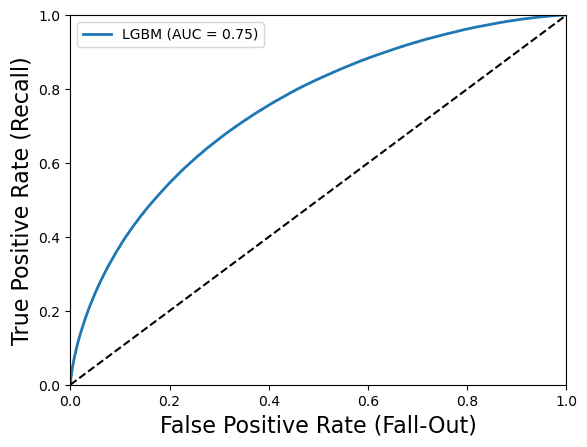

In [13]:
# 가장 큰 데이터셋에 대해서, ROC 커브 그리기
for model_name, model_roc_curves in roc_curves.items():
    fpr, tpr = model_roc_curves[-1]  # Select the ROC curve for the largest dataset size
    plot_roc_curve(fpr, tpr, label=f"{model_name} (AUC = {auc_scores[model_name][-1]:.2f})")
plt.legend()
plt.show()

# 실제 예측 값 확인

In [14]:
user_id = 38

In [15]:
def recommend_top_n(user_id, model, n=5):
    # 아직 유저가 평가하지 않은 애니 가져오기
    user_data = data[data['user_id'] == user_id]
    rated_animes = user_data['anime_id'].unique()
    unrated_animes = item_features[~item_features.index.isin(rated_animes)]
    
    # 유저 정보 붙여주기
    user_features_df = user_features.loc[user_id]
    unrated_animes = unrated_animes.assign(**user_features_df)

    # 해당 유저 대상으로 모델 예측
    unrated_animes['predicted_rating'] = model.predict_proba(unrated_animes)[:, 1]

    # 상위 N개의 평점 예측
    top_n_animes = unrated_animes.sort_values('predicted_rating', ascending=False).head(n)

    return top_n_animes

In [16]:
# 특정 유저에 대한 상위 n개 예측 생성
top_n = recommend_top_n(user_id, models['LGBM'], n=5)[['predicted_rating']]

# top n개 예측의 상세 정보
top_n_details = top_n.merge(animes, how='left', left_index=True, right_on='anime_id')

print(f'Top 5 anime recommendations for user {user_id}:')
display(top_n_details)

Top 5 anime recommendations for user 38:


,predicted_rating,anime_id,type,anime_total_rating,members,name,genre
7045,0.927793,10313,Movie,5.77,301,Dallos Special,Fantasy
4029,0.927328,14059,OVA,6.82,625,Kimagure Orange☆Road: Soushuuhen Tanabata Special,Shounen
6852,0.919738,24637,Special,5.89,302,G-On Riders Special,"Comedy, Ecchi, Sci-Fi"
4074,0.919738,20999,Special,6.81,387,Mini Van Special,"Comedy, Game, Parody, Slice of Life"
2444,0.919738,27567,Special,7.25,943,Fushigi Yuugi Special: Nakago Shikkari Shinasai!,Comedy


In [17]:
# 좋은 평점을 준 애니 검색
user_ratings = ratings[ratings['user_id'] == user_id]
well_rated_animes = user_ratings[user_ratings['rating'] >= user_ratings['rating'].mean()]

# 상세 정보 조회
well_rated_details = animes[animes['anime_id'].isin(well_rated_animes['anime_id'])]

# 평점 정보를 포함한 좋은 평점 정보 출력
well_rated_details = well_rated_details.merge(well_rated_animes[['anime_id', 'rating']], on='anime_id', how='inner')


In [18]:
well_rated_details.head()

,anime_id,type,anime_total_rating,members,name,genre,rating
0,5114,TV,9.26,793665,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",10
1,32935,TV,9.15,93351,Haikyuu!!: Karasuno Koukou VS Shiratorizawa Ga...,"Comedy, Drama, School, Shounen, Sports",10
2,11061,TV,9.13,425855,Hunter x Hunter (2011),"Action, Adventure, Shounen, Super Power",10
3,918,TV,9.04,336376,Gintama,"Action, Comedy, Historical, Parody, Samurai, S...",7
4,2904,TV,8.98,572888,Code Geass: Hangyaku no Lelouch R2,"Action, Drama, Mecha, Military, Sci-Fi, Super ...",10


In [19]:
sample_idx = data[data.user_id==user_id].index[0]

In [20]:
X_test[X_test.index==sample_idx]

,User-AvgRating,User-NumRatings,Item-NumRatings,chan,ga,movie,ni,no,special,specials,...,to,wa,Type-Movie,Type-Music,Type-ONA,Type-OVA,Type-Special,Type-TV,members,anime_total_rating
11,6.703557,253,19488,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,535892,7.46


In [21]:
user_features[user_features.index==user_id]

,User-AvgRating,User-NumRatings
user_id,,
38,6.703557,253


In [22]:
from lime.lime_tabular import LimeTabularExplainer

# LGBM 모델 로드 
model = models['LGBM']

# instance 선택
instance = X_test[X_test.index==sample_idx].values[0]

# explainer 초기화 
explainer = LimeTabularExplainer(X_train_sample.values, 
                                 feature_names=X_train_sample.columns, 
                                 class_names=['0', '1'], 
                                 verbose=True, 
                                 mode='classification')

# 예측 결과 설명 생성 
exp = explainer.explain_instance(instance, model.predict_proba)

# 설명 시각화 
exp.show_in_notebook(show_table=True)


Intercept 0.5587040913696107
Prediction_local [0.45661003]
Right: 0.4450840363690045


/opt/homebrew/Caskroom/miniforge/base/envs/bq_python/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


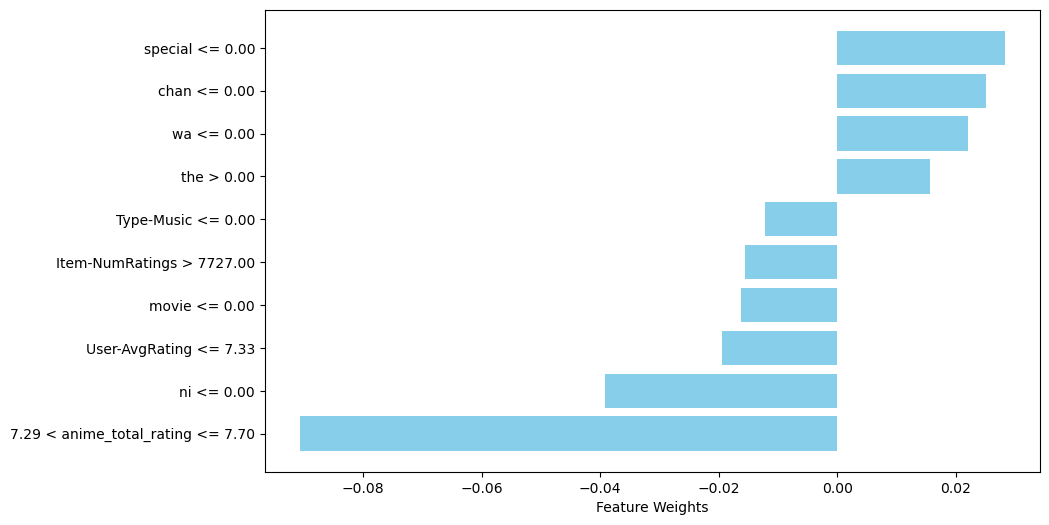

In [23]:
# 피처 리스트 및 그에 해당하는 가중치 
features = exp.as_list()

# 가중치 절댓값 크기에 따라 피처 정렬
# features.sort(key=lambda x: np.abs(x[1]), reverse=True)

# 가중치 값에 따라 피처 정렬
features.sort(key=lambda x: x[1], reverse=True)

# 두 리스트로 나누기
feature_names, feature_weights = zip(*features)

# 바 플랏 그리기
plt.figure(figsize=(10, 6))
plt.barh(feature_names, feature_weights, color='skyblue')
plt.xlabel('Feature Weights')
plt.gca().invert_yaxis()
plt.show()


In [28]:
%%time
import shap

# shap tree explainer 인스턴스 생성 
shap_explainer = shap.TreeExplainer(model)

# test set 대상으로 shap value 생성 
shap_values = shap_explainer.shap_values(X_test)

CPU times: user 4min 50s, sys: 8.43 s, total: 4min 58s
Wall time: 44.3 s


/opt/homebrew/Caskroom/miniforge/base/envs/bq_python/lib/python3.9/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


In [31]:
# 테스트 셋 내의 한 인스턴스에 대해 시각화
# 기본 값으로부터(모델이 셋팅한 베이스라인, shap_explainer.expected_value) 얼마나 각 피처가 출력 값을 밀어냈는지 계싼

# 입력 값
# shap_explainer.expected_value[1]: 모델 출력 값의 기본 값, 기댓값
# shap_values[1,:]: 테스트 셋 내 내가 지정한, 확인하고 싶은 인덱스에 해당하는 shap value
# X_test.iloc[1,:]: 실제 피처 값

shap.initjs()
shap.force_plot(shap_explainer.expected_value, 
                shap_values[1,:],
                X_test.iloc[1,:])

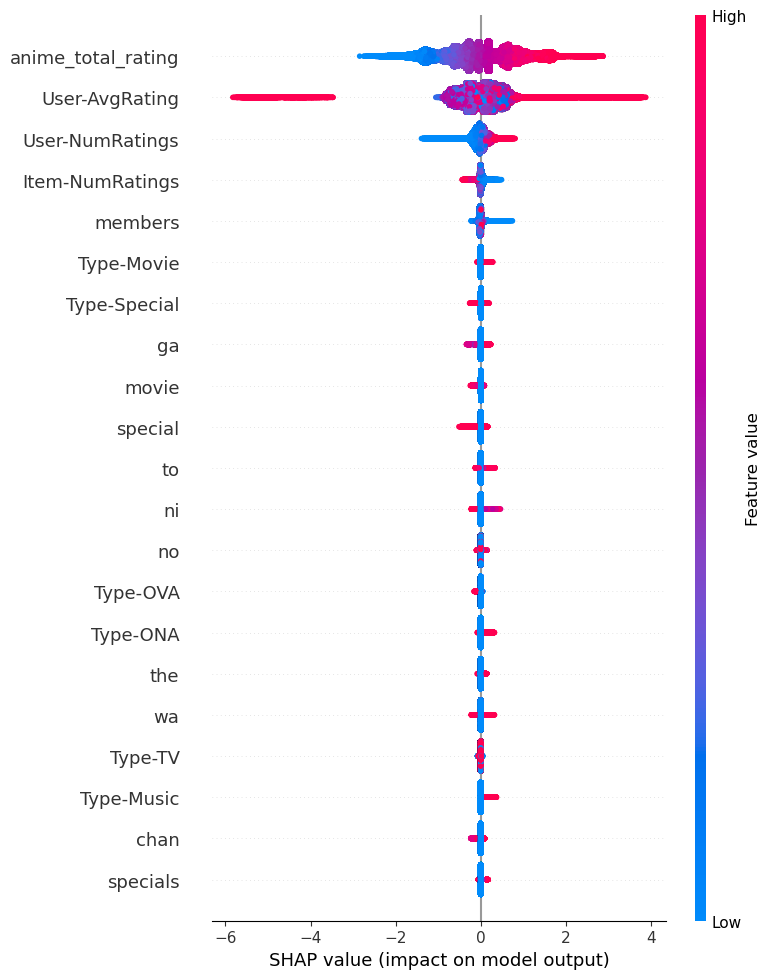

In [32]:
shap.summary_plot (shap_values, X_test, max_display=X_test.shape[1]) 